In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
from pathlib import Path

columns = ["user_id", "movie_id", "rating", "timestamp"]

data_path = Path("data/u.csv")

if data_path.exists():
    ratings = pd.read_csv(
        data_path,
        header=None,
        names=columns
    )
else:
    print("No se encontró 'data/u.csv'. Se usa un DataFrame de ejemplo.")

ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [27]:
print("Número de registros:", ratings.shape[0])
print("Usuarios únicos:", ratings["user_id"].nunique())
print("Películas únicas:", ratings["movie_id"].nunique())

Número de registros: 100000
Usuarios únicos: 943
Películas únicas: 1682


In [28]:
movie_matrix = ratings.pivot_table(
    index="user_id",
    columns="movie_id",
    values="rating"
)

movie_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Rellenar con la media global en lugar de 0s
global_mean = ratings["rating"].mean()
movie_matrix_filled = movie_matrix.fillna(global_mean)
print(f"Media global del dataset: {global_mean:.2f}")

Media global del dataset: 3.53


In [30]:
U, S, Vt = np.linalg.svd(movie_matrix_filled, full_matrices=False)

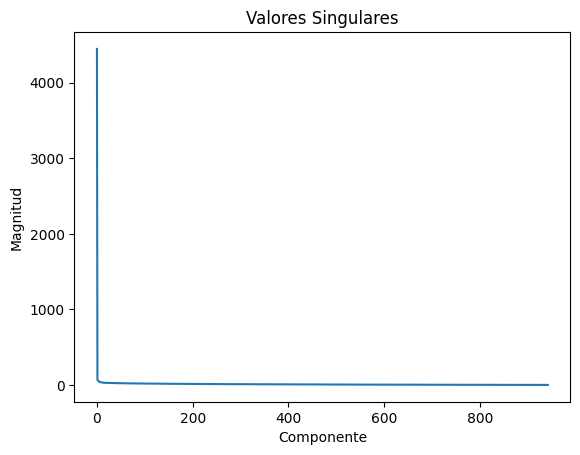

In [31]:
plt.figure()
plt.plot(S)
plt.title("Valores Singulares")
plt.xlabel("Componente")
plt.ylabel("Magnitud")
plt.show()

In [32]:
k = 20

U_k = U[:, :k]
S_k = np.diag(S[:k])
Vt_k = Vt[:k, :]

reconstructed_matrix = U_k @ S_k @ Vt_k

In [33]:
# Usar indexación correcta con .loc
user_id = 196
movie_id = 242

# Convertir la matriz reconstruida de vuelta a DataFrame
reconstructed_df = pd.DataFrame(
    reconstructed_matrix,
    index=movie_matrix.index,
    columns=movie_matrix.columns
)

predicted_rating = reconstructed_df.loc[user_id, movie_id]

print(f"Rating real: {movie_matrix.loc[user_id, movie_id]}")
print(f"Predicción SVD: {predicted_rating:.2f}")

Rating real: 3.0
Predicción SVD: 3.62


In [34]:
# Validación: separar train/test
from sklearn.model_selection import train_test_split

# Dividir ratings en train (80%) y test (20%)
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Crear matriz solo con datos de entrenamiento
train_matrix = train_data.pivot_table(
    index="user_id",
    columns="movie_id",
    values="rating"
)

# Rellenar y aplicar SVD
global_mean_train = train_data["rating"].mean()
train_matrix_filled = train_matrix.fillna(global_mean_train)
U_train, S_train, Vt_train = np.linalg.svd(train_matrix_filled, full_matrices=False)

# Reconstruir con k=20
U_k_train = U_train[:, :k]
S_k_train = np.diag(S_train[:k])
Vt_k_train = Vt_train[:k, :]
reconstructed_train = U_k_train @ S_k_train @ Vt_k_train

# Convertir a DataFrame
reconstructed_df_train = pd.DataFrame(
    reconstructed_train,
    index=train_matrix.index,
    columns=train_matrix.columns
)

# Evaluar en test set
predictions = []
actuals = []

for _, row in test_data.iterrows():
    uid, mid, rating = row["user_id"], row["movie_id"], row["rating"]
    if uid in reconstructed_df_train.index and mid in reconstructed_df_train.columns:
        pred = reconstructed_df_train.loc[uid, mid]
        # Limitar predicción a rango 1-5
        pred = np.clip(pred, 1, 5)
        predictions.append(pred)
        actuals.append(rating)

rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"RMSE en test set: {rmse:.4f}")
print(f"Ratings evaluados: {len(predictions)} de {len(test_data)}")

RMSE en test set: 1.0373
Ratings evaluados: 19969 de 20000


k=5: RMSE=1.0454
k=10: RMSE=1.0367
k=20: RMSE=1.0373
k=50: RMSE=1.0560
k=100: RMSE=1.0787
k=150: RMSE=1.0938


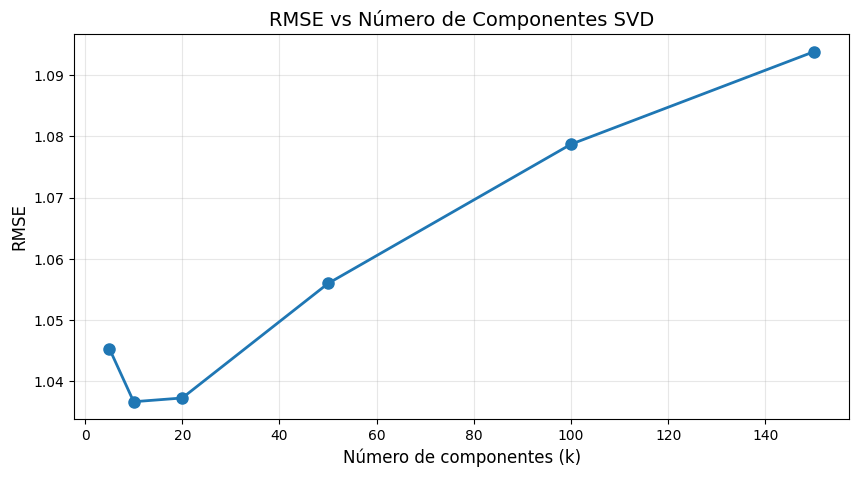


Mejor k: 10 con RMSE=1.0367


In [35]:
# Optimizar k: probar diferentes valores
ks = [5, 10, 20, 50, 100, 150]
rmse_values = []

for k_val in ks:
    U_k_temp = U_train[:, :k_val]
    S_k_temp = np.diag(S_train[:k_val])
    Vt_k_temp = Vt_train[:k_val, :]
    recon_temp = U_k_temp @ S_k_temp @ Vt_k_temp
    
    recon_df_temp = pd.DataFrame(recon_temp, index=train_matrix.index, columns=train_matrix.columns)
    
    preds = []
    acts = []
    for _, row in test_data.iterrows():
        uid, mid, rating = row["user_id"], row["movie_id"], row["rating"]
        if uid in recon_df_temp.index and mid in recon_df_temp.columns:
            preds.append(np.clip(recon_df_temp.loc[uid, mid], 1, 5))
            acts.append(rating)
    
    rmse_values.append(np.sqrt(mean_squared_error(acts, preds)))
    print(f"k={k_val}: RMSE={rmse_values[-1]:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(ks, rmse_values, marker='o', linewidth=2, markersize=8)
plt.xlabel('Número de componentes (k)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE vs Número de Componentes SVD', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nMejor k: {ks[np.argmin(rmse_values)]} con RMSE={min(rmse_values):.4f}")

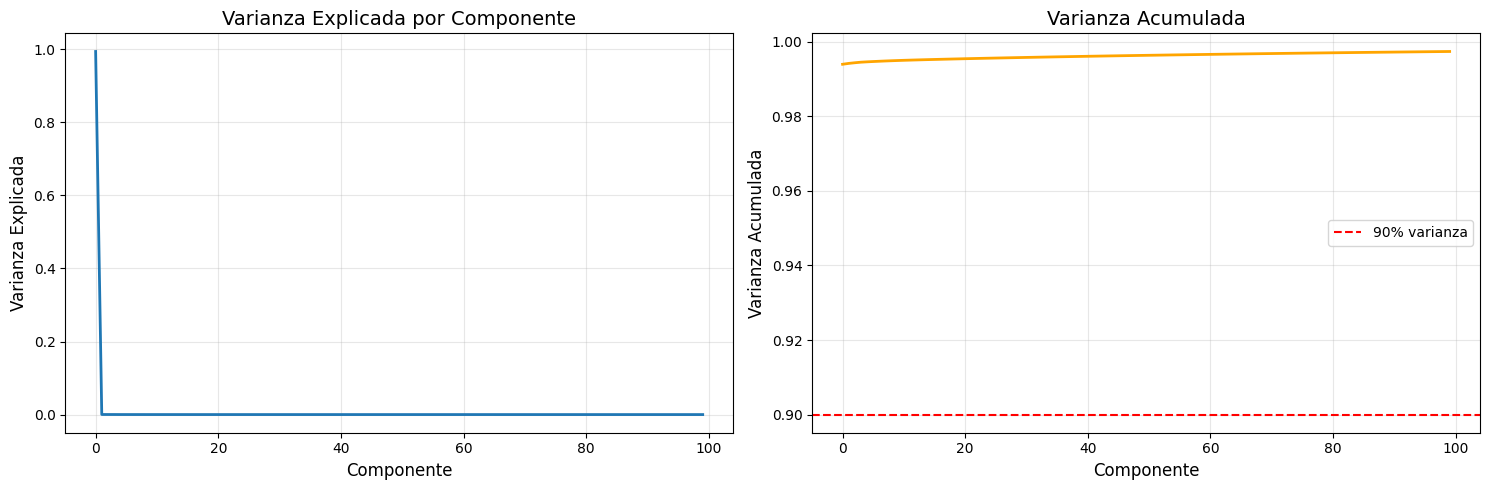


Primeros 20 componentes explican: 99.54% de la varianza
Se necesitan 1 componentes para explicar el 90% de la varianza
Total de componentes disponibles: 943


In [36]:
# Varianza explicada por los componentes
variance_explained = (S**2) / (S**2).sum()
cumulative_variance = np.cumsum(variance_explained)

# Gráfica de varianza acumulada
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Varianza individual
axes[0].plot(variance_explained[:100], linewidth=2)
axes[0].set_xlabel('Componente', fontsize=12)
axes[0].set_ylabel('Varianza Explicada', fontsize=12)
axes[0].set_title('Varianza Explicada por Componente', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Varianza acumulada
axes[1].plot(cumulative_variance[:100], linewidth=2, color='orange')
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% varianza')
axes[1].set_xlabel('Componente', fontsize=12)
axes[1].set_ylabel('Varianza Acumulada', fontsize=12)
axes[1].set_title('Varianza Acumulada', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar cuántos componentes explican el 90% de la varianza
k_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"\nPrimeros 20 componentes explican: {cumulative_variance[19]*100:.2f}% de la varianza")
print(f"Se necesitan {k_90} componentes para explicar el 90% de la varianza")
print(f"Total de componentes disponibles: {len(S)}")

In [37]:
# Top N recomendaciones para un usuario específico
user_id = 196

# Obtener ratings del usuario
user_ratings = movie_matrix.loc[user_id]

# Identificar películas no calificadas
not_rated = user_ratings[user_ratings.isna()]

# Obtener predicciones para esas películas
predictions_for_user = reconstructed_df.loc[user_id, not_rated.index]

# Top 10 recomendaciones
top_10 = predictions_for_user.nlargest(10)

print(f"Top 10 películas recomendadas para usuario {user_id}:")
print("-" * 50)
for movie_id, predicted_rating in top_10.items():
    print(f"Película ID: {movie_id:4d} | Rating predicho: {predicted_rating:.2f}")

# Mostrar algunas películas que el usuario ya calificó bien
print(f"\nPelículas que el usuario {user_id} calificó con 5 estrellas:")
print("-" * 50)
high_ratings = user_ratings[user_ratings == 5.0].head(5)
for movie_id, rating in high_ratings.items():
    print(f"Película ID: {movie_id:4d} | Rating real: {rating:.0f}")

Top 10 películas recomendadas para usuario 196:
--------------------------------------------------
Película ID:    9 | Rating predicho: 3.75
Película ID:  100 | Rating predicho: 3.74
Película ID:   56 | Rating predicho: 3.73
Película ID:  275 | Rating predicho: 3.72
Película ID:   14 | Rating predicho: 3.71
Película ID:  302 | Rating predicho: 3.71
Película ID:  127 | Rating predicho: 3.70
Película ID:  276 | Rating predicho: 3.70
Película ID:   15 | Rating predicho: 3.68
Película ID:  318 | Rating predicho: 3.68

Películas que el usuario 196 calificó con 5 estrellas:
--------------------------------------------------
Película ID:    8 | Rating real: 5
Película ID:   67 | Rating real: 5
Película ID:  153 | Rating real: 5
Película ID:  285 | Rating real: 5
Película ID:  286 | Rating real: 5
